In [1]:
#数据预处理
%matplotlib inline
import tensorflow as tf
import numpy as np
import os
from time import time
from scipy.signal import welch
from scipy.interpolate import  interp1d as interp
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import scale
from sklearn.model_selection import StratifiedKFold 
from tensorflow.keras.utils import Progbar
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
class Preprocessing(object):
    """
    对序列进行提取特征等预处理
    为了可能处理变长序列,因此输入为list
    """
    def __init__(self,with_label=True):
        self.with_label=with_label
    def __call__(self,sequence):
        for i in range(len(sequence)):
            time_point=np.expand_dims(sequence[i][0],axis=0)
            if self.with_label:
                label=np.expand_dims(sequence[i][-1],axis=0)
                new_sequence=self.for_each(sequence[i][1:-1])
                sequence[i]=np.concatenate([time_point,new_sequence,label],axis=0)
            else:
                new_sequence=self.for_each(sequence[i][1:])
                sequence[i]=np.concatenate([time_point,new_sequence],axis=0)
        sequence=self.for_all(sequence)
        return sequence
    def smooth(self,array,decay_rate=0.9):
        _smooth=np.zeros(array.shape)
        for i in range(1,len(array)-1):
            decay=min(decay_rate,(i+1)/(i+10))
            _smooth[i]=_smooth[i-1]*decay+(1-decay)*array[i]
        return _smooth
    def for_all(self,sequence):#变长序列可以numpy吗#
        return sequence
        mean=np.zeros(shape=sequence[0].shape[0])
        std=np.zeros(shape=sequence[0].shape[0])
        lenth=len(sequence)
        for index in range(lenth):
            if self.with_label:
                _range=range(1,sequence[index].shape[0]-1)
            else:
                _range=range(1,sequence[index].shape[0])
            for i in _range:
                mean[i]+=sequence[index][i].mean()/lenth
                std[i]+=sequence[index][i].std()/lenth
        for index in range(lenth):
            if self.with_label:
                _range=range(1,sequence[index].shape[0]-1)
            else:
                _range=range(1,sequence[index].shape[0])
            for i in _range:
                sequence[index][i]=(sequence[index][i]-mean[i])/std[i]
        return sequence
    def for_each(self,sequence):
        acc=(sequence[0]**2+sequence[1]**2+sequence[2]**2)**0.5
        acc=np.expand_dims(acc,axis=0)
        acc_g=(sequence[3]**2+sequence[4]**2+sequence[5]**2)**0.5
        acc_g=np.expand_dims(acc_g,axis=0)
        sequence=np.concatenate([sequence,acc,acc_g],axis=0)
        return sequence

In [2]:
#加载数据
class DatasetLoader(object):
    def __init__(self,csv_file,with_label=True,num_classes=19):
        self.csv_file=csv_file
        self.with_label=with_label
        self.format="channel_last"
        self.split=False
        self.names=self.get_feature_names()
        self.num_classes=num_classes
        self.data_split=False
    def get_feature_names(self):
         with open(self.csv_file) as f:
            examples={}
            names=f.readline().split(',')[1:]
            names[-1]=names[-1][:-1]
            return names
    def make_numpy(self,num_interpolation=200,with_label=True):
        '''将数据读取并保存为Numpy数组
               Args:
                 num_interpolation:差值法采样点个数
                 with_label：是否带标签
               Returns:
                 A list,shape=[num_examples,keys,length]
        '''
        #数据读取
        if self.csv_file is None:
            raise ValueError("sub dataset cannnot get numpy data")
        print("Loading date...")
        line={}
        with open(self.csv_file) as f:
            examples={}
            names=f.readline().split(',')[1:]
            names[-1]=names[-1][:-1]
            while True:
                try:
                    line=f.readline().split(",")
                    if line is None:
                        break
                    for i in range(len(line)):
                        line[i]=eval(line[i])
                    if not line[0] in examples:
                        examples[line[0]]=[]
                    examples[line[0]].append(line[1:])
                except:
                    break
        print("done")
        #格式转换            
        for i in range(len(examples)):
            examples[i]=np.array(examples[i]).transpose([1,0])
        self.examples=examples=list(examples.values())
        return self
    def resample(self,num_interpolation=200):
        examples=self.examples
        print("interpolate")
        bar=Progbar(len(examples))#进度条
        if num_interpolation and num_interpolation is not None:
            for i in range(len(examples)):
                range_len=examples[i][0][-1]-examples[i][0][0]
                range_start=examples[i][0][0]
                range_interval=range_len/num_interpolation
                interp_x=[range_start+range_interval*i for i in range(num_interpolation)]
                interp_data=[interp_x]
                for feature_id in range(1,len(self.names)):
                    try:
                        interp_f=interp(examples[i][0],examples[i][feature_id],kind="cubic")
                        interp_data.append([interp_f(x)for x in interp_x])
                    except:
                        raise ValueError("%d %d"%(i,feature_id),examples[i])
                bar.update(i)
                examples[i]=np.array(interp_data)
        print("\ndone")
        #数据预处理
        preprocession=Preprocessing(with_label=self.with_label)
        examples=preprocession(examples)
        self.examples=np.array(examples,dtype="float32")    
        if self.with_label:
            self.y=self.examples[::,-1,0].tolist()
            self.x=self.examples[::,1:-1,::]
        else:
            self.x=self.examples[::,1:,::]
        return self
    def apply_class_weights(self):
        weights=np.zeros([self.num_classes])
        for i in range(len(weights)):
            weights[i]=(self.examples[::,-1:,0]==i).sum()
        return weights/weights.sum()
    def data_format(string="channel_last"):
        if not string in ["channel_first","channel_last"]:
            raise ValueError("either channel_last or channel_first are supported")
        self.format=string
    def apply_data(self):
        if self.with_label:
            if self.split:
                if self.format=="channel_first":
                    return self.x_train,self.y_train,self.x_test,self.y_test
                else:
                    return self.x_train.transpose([0,2,1]),self.y_train,self.x_test.transpose([0,2,1]),self.y_test
                    
            else:
                if self.format=="channel_first":
                    return self.x,self.y
                else:
                    return self.x.transpose([0,2,1]),self.y
        else:
            if self.format=="channel_first":
                return self.x
            else:
                return self.x.transpose([0,2,1])


In [3]:
#metrics
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
def single_score(y, y_pred):
    # 数值ID与行为编码的对应关系
    mapping = {0: 'A_0', 1: 'A_1', 2: 'A_2', 3: 'A_3', 
        4: 'D_4', 5: 'A_5', 6: 'B_1',7: 'B_5', 
        8: 'B_2', 9: 'B_3', 10: 'B_0', 11: 'A_6', 
        12: 'C_1', 13: 'C_3', 14: 'C_0', 15: 'B_6', 
        16: 'C_2', 17: 'C_5', 18: 'C_6'}
    # 将行为ID转为编码
    code_y, code_y_pred = mapping[y], mapping[y_pred]
    if code_y == code_y_pred: #编码完全相同得分1.0
        return 1.0
    elif code_y.split("_")[0] == code_y_pred.split("_")[0]: #编码仅字母部分相同得分1.0/7
        return 1.0/7
    elif code_y.split("_")[1] == code_y_pred.split("_")[1]: #编码仅数字部分相同得分1.0/3
        return 1.0/3
    else:
        return 0.0
def py_score(y_true,y_pred):
    y_true=np.argmax(y_true,axis=-1)
    y_pred=np.argmax(y_pred,axis=-1)
    scores=[]
    for i in range(len(y_true)):
        scores.append(single_score(y_true[i],y_pred[i]))
    mean_score=np.array(scores,dtype="float32").mean()
    return mean_score,mean_score
def score(y_true,y_pred):
    """线上评测所使用的评测方法
    Args:
      y_true:one_hot编码的标签
      y_pred:网络类别置信度预测
    Returns:
      Tensor标量
    """
    mean_score=tf.py_func(py_score,[y_true,y_pred],[tf.float32,tf.float32])[0]
    return tf.reshape(mean_score,shape=())

In [4]:
#网络结构
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Softmax
from tensorflow.keras.layers import Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from extend import WeightDecayScheduler,AdamW
class SoftThreshold(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super(SoftThreshold,self).__init__(**kwargs)
    def call(self,inputs):
        tensor=inputs[0]
        threshold=inputs[0]*inputs[1]
        threshold=tf.abs(threshold)
        less=tf.cast(tf.less(tensor,-threshold),tf.float32)
        greater=tf.cast(tf.greater(tensor,threshold),tf.float32)
        tensor=(tensor-threshold)*greater+(tensor+threshold)*less
        return tensor
class SKNet(object):
    def __init__(self,filters,kernel_size,activation,dilation_rates=[1,1,1,1]):
        self.filters=filters
        self.kernel_size=kernel_size
        self.dilation_rates=dilation_rates
        self.activation=activation
        self.sk_rate=8
    def branch(self,tensor,dilation_rate):
        x=Conv2D(self.filters,self.kernel_size,1,padding="same",kernel_regularizer=l2(0.00),
                 activation=self.activation,dilation_rate=dilation_rate)(tensor)
        x=BatchNormalization()(x)
        x=Activation(self.activation)(x)
        return x
    def attention(self,tensor):
        add=tf.keras.layers.add(tensor)
        shape=add.shape.as_list()
        squeeze=GlobalAveragePooling2D()(add)
        squeeze=Dense(shape[-1]//self.sk_rate,activation=tf.nn.relu)(squeeze)
        extract=Dense(shape[-1],activation=tf.nn.softmax)(squeeze)
        extract=tf.expand_dims(extract,axis=1)
        extract=tf.expand_dims(extract,axis=1)
        output=[]
        for t in tensor:
            output.append(SoftThreshold()([t,extract]))
        return output
    def pool(self,tensor):
        tensor=Conv2D(self.filters,self.kernel_size,1,padding="same",kernel_regularizer=l2(0.00))(tensor)
        shape=tensor.shape.as_list()#[batch,lenth,channels]
        scaler=AveragePooling2D((shape[1],shape[2]))(tensor)#[batch,channels]
        scaler=UpSampling2D((shape[1],shape[2]))(scaler)
        return scaler
    def __call__(self,tensor):
        x=Conv2D(self.filters,1,1,padding="same",
                 activation=self.activation,kernel_regularizer=l2(0.00))(tensor)
        x=BatchNormalization()(x)
        x=Activation(None)(x)
        output=[x]
        output.append(self.pool(tensor))
        for rate in self.dilation_rates:
            output.append(self.branch(tensor,rate))
        output=self.attention(output)
        output=tf.keras.layers.add(output)
        output=Conv2D(self.filters,3,1,padding="same",kernel_regularizer=l2(0.00))(output)
        output=BatchNormalization()(output)
        output=Activation(self.activation)(output)
        return output

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


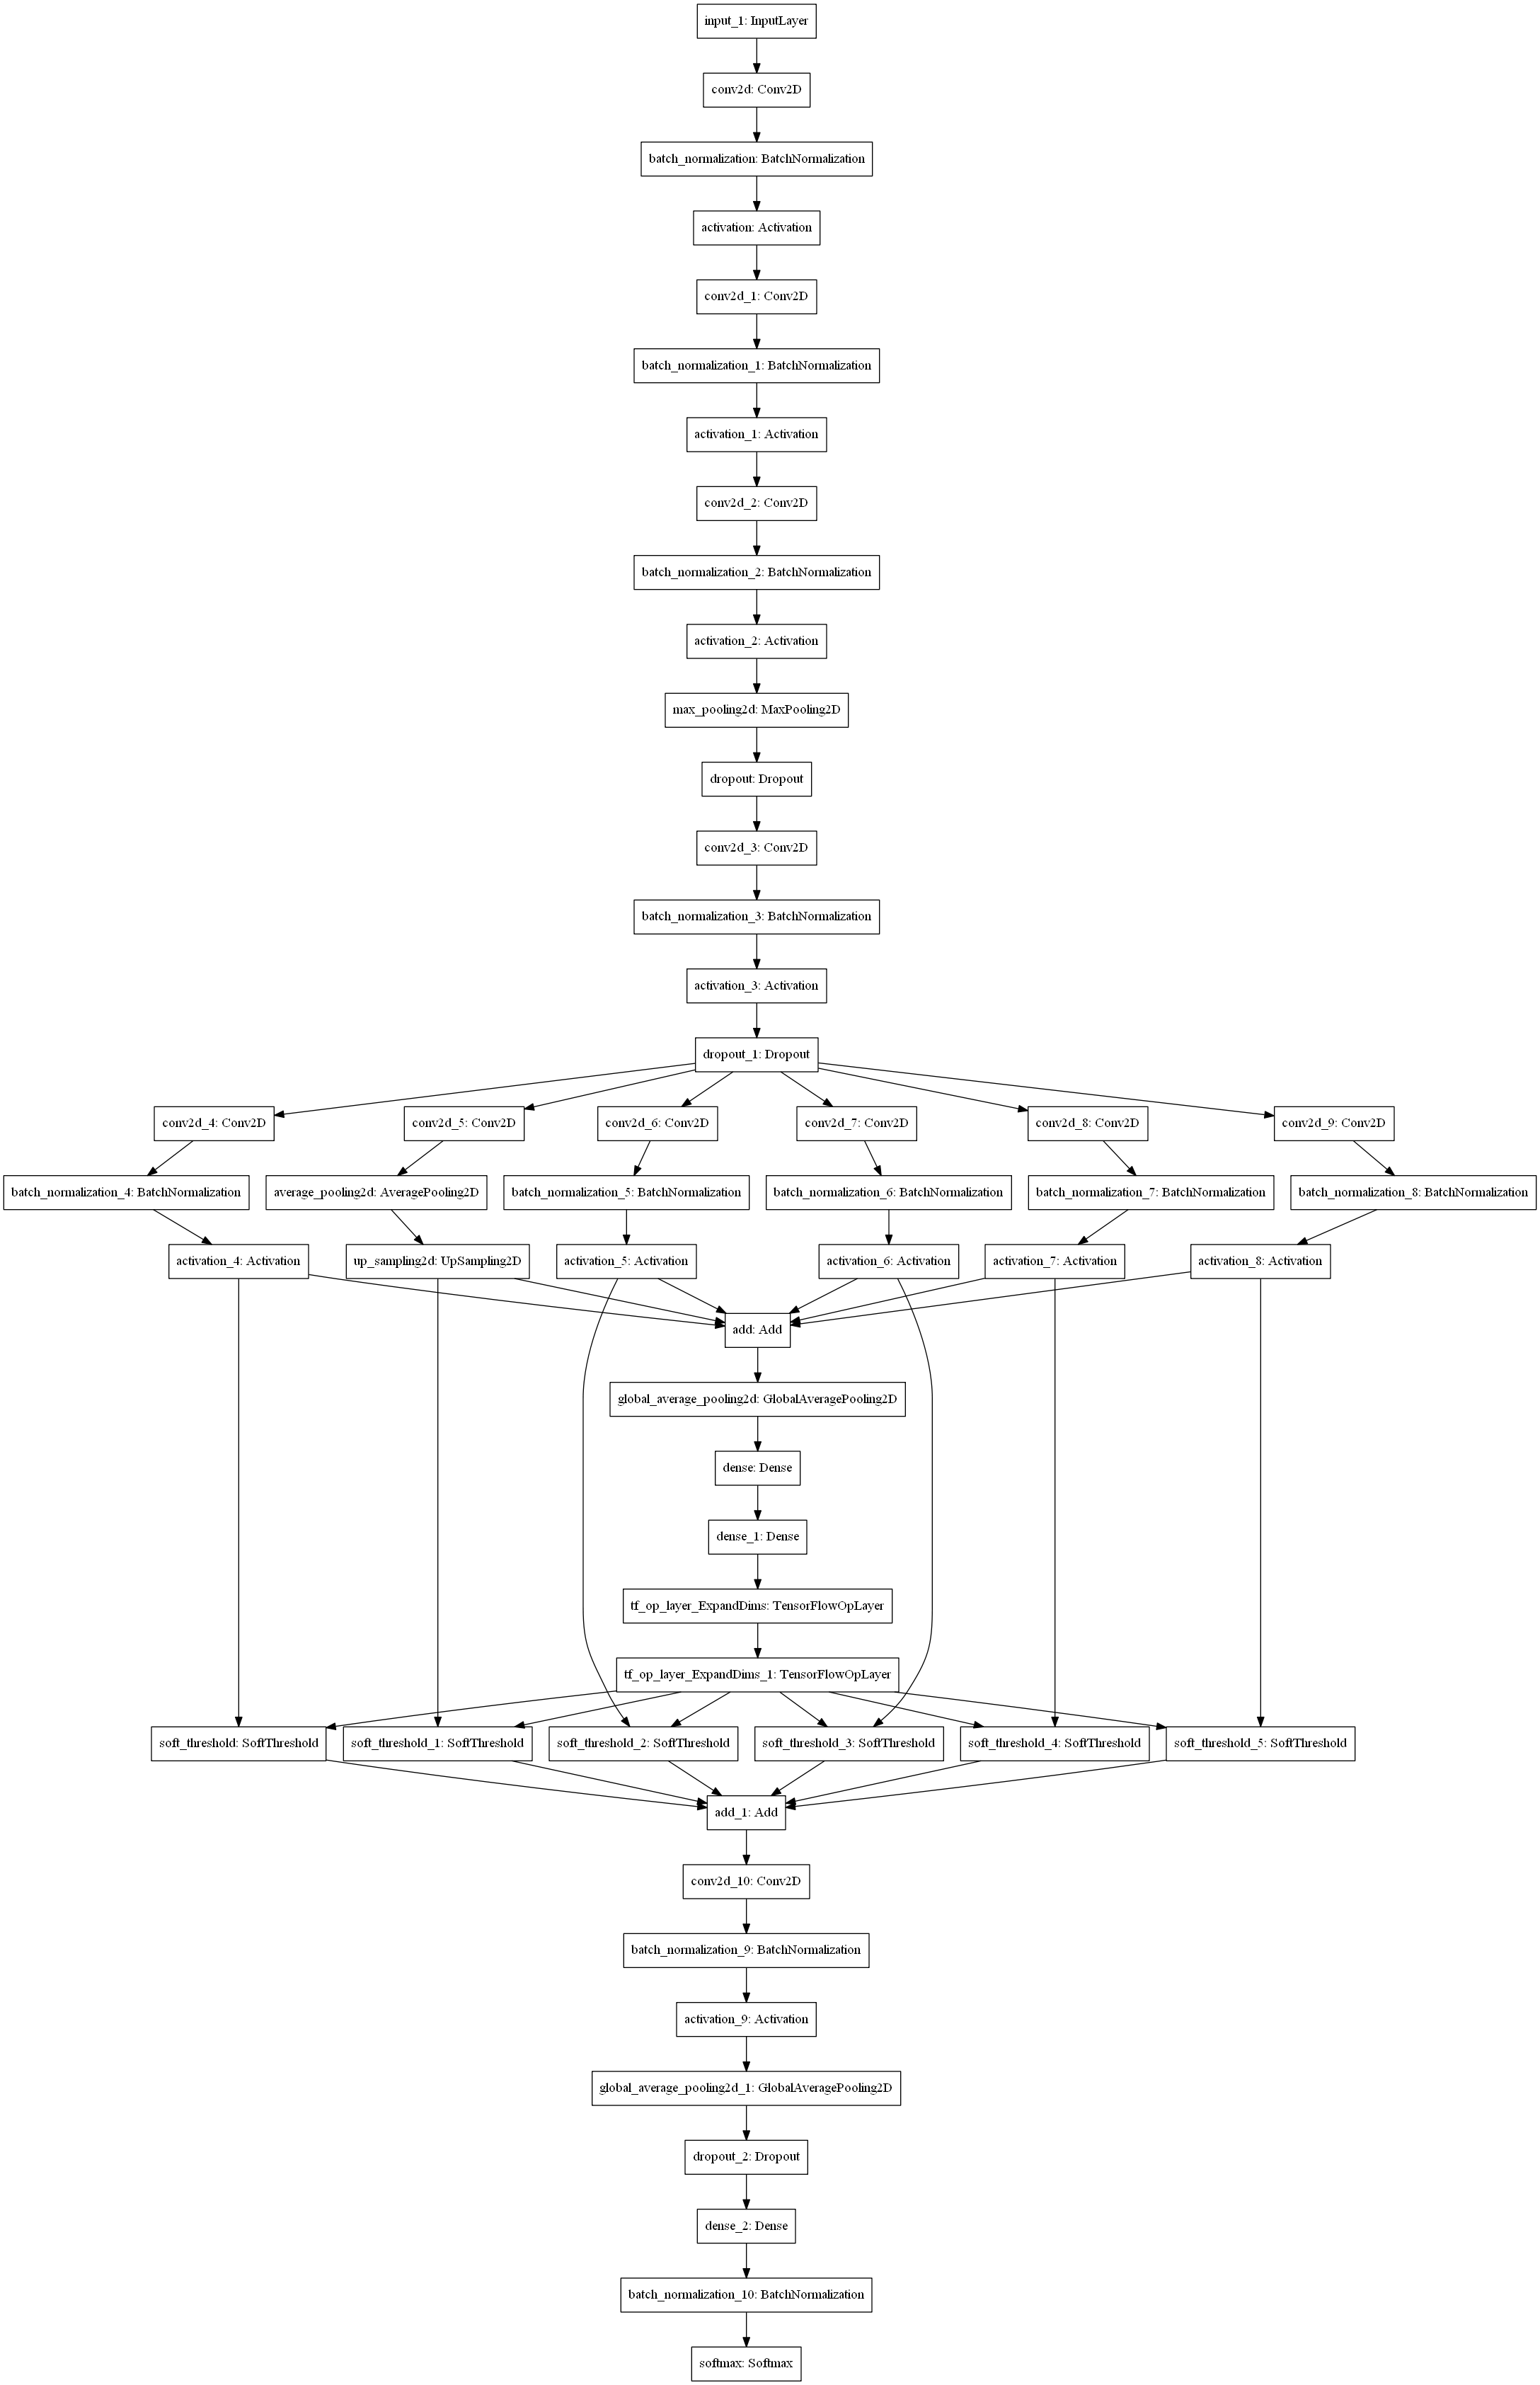

In [5]:
tf.reset_default_graph()
def CNN(inputs,num_classes):
    x=Conv2D(32,3,1,padding="same",kernel_regularizer=l2(0.00))(inputs)
    x=BatchNormalization()(x)
    x=Activation(tf.nn.relu)(x)
    
    x=Conv2D(64,3,1,padding="same",kernel_regularizer=l2(0.00))(x)
    x=BatchNormalization()(x)
    x=Activation(tf.nn.relu)(x)
    
    x=Conv2D(128,3,1,padding="same",kernel_regularizer=l2(0.00))(x)
    x=BatchNormalization()(x)
    x=Activation(tf.nn.relu)(x)
    
    x=MaxPooling2D(2,padding="same")(x)
    x=Dropout(0.5)(x)
    
    x=Conv2D(192,3,1,padding="same",kernel_regularizer=l2(0.00))(x)
    x=BatchNormalization()(x)
    x=Activation(tf.nn.relu)(x)
    x=Dropout(0.5)(x)
    
    x=SKNet(384,3,activation=tf.nn.relu)(x)
    
    x=GlobalAveragePooling2D()(x)
    x=Dropout(0.5)(x)

    x=Dense(num_classes,kernel_regularizer=l2(0))(x)
    x=BatchNormalization()(x)
    x=Softmax()(x)
    return x
#inputs=Input(shape=[64,8,1])
#outputs=CNN(inputs,num_classes=19)
#tf.keras.utils.plot_model(Model(inputs,outputs),show_shapes=False)

In [6]:
#加载数据
tf.reset_default_graph()
csv_file="data\\sensor_train.csv"
test_csv_file="data\\sensor_test.csv"
filepath='best_weights_aspp_raw'
batch_size=64
config=tf.ConfigProto()
config.gpu_options.allow_growth=True   #不全部占满显存, 按需分配
sess=tf.Session(config=config)
K.set_session(sess)
if True:
    dataset=DatasetLoader(csv_file,with_label=True,num_classes=19)
    dataset=dataset.make_numpy()
    #dataset=dataset.reverse()
    dataset=dataset.resample(num_interpolation=64)
    x,y=dataset.apply_data()
    class_weight=dataset.apply_class_weights()
    dataset=DatasetLoader(test_csv_file,with_label=False)
    dataset=dataset.make_numpy()
    #dataset=dataset.reverse()
    dataset=dataset.resample(num_interpolation=64)
    x_val=dataset.apply_data()
    x=np.expand_dims(x,axis=-1)
    x_val=np.expand_dims(x_val,axis=-1)
x.shape

Loading date...
done
interpolate
7288/7292 [============================>.] - ETA: 0s
done
Loading date...
done
interpolate
7495/7500 [============================>.] - ETA: 0s
done


(7292, 64, 8, 1)

In [ ]:
#模型加载与训练
from tensorflow.keras.utils import to_categorical
config=tf.ConfigProto()
config.gpu_options.allow_growth=True   #不全部占满显存, 按需分配
sess=tf.Session(config=config)
K.set_session(sess)
kfold = StratifiedKFold(5, shuffle=True,random_state=12255877)
proba_t = np.zeros((7500, 19))
train_score=[]
test_score=[]
for fold,(xx,yy) in enumerate(kfold.split(x,y)):
    tf.reset_default_graph()
    inputs=Input(shape=[64,8,1])
    outputs=CNN(inputs,num_classes=19)
    model=Model(inputs=inputs,outputs=outputs)
    _y=to_categorical(y,19)
    plateau=ReduceLROnPlateau(monitor="val_score",
                                verbose=1,
                                mode='max',
                                factor=0.4,
                                patience=20)
    early_stopping=EarlyStopping(monitor='val_acc',
                                   verbose=1,
                                   mode='max',
                                   patience=50)
    checkpoint=ModelCheckpoint(f'aspp_baseline{fold}.h5',
                                 monitor='val_score',
                                 verbose=1,
                                 mode='max',
                                 save_best_only=True)
    weight_decay=WeightDecayScheduler(init_lr=0.001)
    model.compile(loss='categorical_crossentropy',optimizer=AdamW(lr=0.001,weight_decay=4e-4),metrics=["acc",score])
    trained_model=model.fit(
            x[xx],
            _y[xx],
            batch_size=batch_size,
            class_weight=(1-class_weight)**2,
            shuffle=True,
            validation_data=(x[yy],_y[yy]),
            epochs=800,
            callbacks=[plateau,early_stopping,checkpoint,weight_decay])
    model.load_weights(f'aspp_baseline{fold}.h5')
    proba_t+=model.predict(x_val, verbose=0, batch_size=1024)/5.
    train_score.append(np.array(trained_model.history["score"]).max())
    test_score.append(np.array(trained_model.history["val_score"]).max())
label=proba_t.argmax(axis=1)
print("on_train_set:",np.array(train_score))
print("average:",np.array(train_score).mean())
print("on_test_set:",np.array(test_score))
print("average:",np.array(test_score).mean())
print("done")

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
Train on 5825 samples, validate on 1467 samples
0 1.0000000474974513
Epoch 1/800
5760/5825 [============================>.] - ETA: 0s - loss: 2.2133 - acc: 0.2806 - score: 0.3701
Epoch 00001: val_score improved from -inf to 0.20179, saving model to aspp_baseline0.h5
5825/5825 [==============================] - 11s 2ms/sample 

Epoch 47/800
5824/5825 [============================>.] - ETA: 0s - loss: 0.8846 - acc: 0.7617 - score: 0.7972
Epoch 00047: val_score did not improve from 0.72376
5825/5825 [==============================] - 5s 885us/sample - loss: 0.8850 - acc: 0.7615 - score: 0.7886 - val_loss: 2.1455 - val_acc: 0.4724 - val_score: 0.5421
Epoch 48/800
5824/5825 [============================>.] - ETA: 0s - loss: 0.8804 - acc: 0.7579 - score: 0.7942
Epoch 00048: val_score did not improve from 0.72376
5825/5825 [==============================] - 5s 888us/sample - loss: 0.8808 - acc: 0.7578 - score: 0.7855 - val_loss: 1.9462 - val_acc: 0.4581 - val_score: 0.5285
Epoch 49/800
5824/5825 [============================>.] - ETA: 0s - loss: 0.8751 - acc: 0.7670 - score: 0.8008
Epoch 00049: val_score did not improve from 0.72376
5825/5825 [==============================] - 5s 895us/sample - loss: 0.8755 - acc: 0.7669 - score: 0.7921 - val_loss: 1.2476 - val_acc: 0.6292 - val_score: 0.6803
Epoch 50/800
5824/5825

Epoch 72/800
5824/5825 [============================>.] - ETA: 0s - loss: 0.5545 - acc: 0.8896 - score: 0.9067
Epoch 00072: val_score did not improve from 0.81855
5825/5825 [==============================] - 5s 885us/sample - loss: 0.5549 - acc: 0.8894 - score: 0.8984 - val_loss: 0.9069 - val_acc: 0.7396 - val_score: 0.7745
Epoch 73/800
5824/5825 [============================>.] - ETA: 0s - loss: 0.5334 - acc: 0.8959 - score: 0.9117
Epoch 00073: val_score did not improve from 0.81855
5825/5825 [==============================] - 5s 893us/sample - loss: 0.5338 - acc: 0.8960 - score: 0.9127 - val_loss: 1.2709 - val_acc: 0.6558 - val_score: 0.7007
Epoch 74/800
5824/5825 [============================>.] - ETA: 0s - loss: 0.5309 - acc: 0.8935 - score: 0.9095
Epoch 00074: val_score did not improve from 0.81855
5825/5825 [==============================] - 5s 888us/sample - loss: 0.5314 - acc: 0.8934 - score: 0.9011 - val_loss: 1.5709 - val_acc: 0.5808 - val_score: 0.6334
Epoch 75/800
5824/5825

Epoch 97/800
5824/5825 [============================>.] - ETA: 0s - loss: 0.5064 - acc: 0.8985 - score: 0.9146
Epoch 00097: val_score did not improve from 0.83320
5825/5825 [==============================] - 5s 890us/sample - loss: 0.5067 - acc: 0.8984 - score: 0.9083 - val_loss: 0.9436 - val_acc: 0.7355 - val_score: 0.7716
Epoch 98/800
5824/5825 [============================>.] - ETA: 0s - loss: 0.4732 - acc: 0.9126 - score: 0.9256
Epoch 00098: val_score did not improve from 0.83320
5825/5825 [==============================] - 5s 892us/sample - loss: 0.4736 - acc: 0.9126 - score: 0.9264 - val_loss: 0.8449 - val_acc: 0.7648 - val_score: 0.7983
Epoch 99/800
5824/5825 [============================>.] - ETA: 0s - loss: 0.4642 - acc: 0.9198 - score: 0.9327- ETA: 2s - l
Epoch 00099: val_score did not improve from 0.83320
5825/5825 [==============================] - 5s 891us/sample - loss: 0.4646 - acc: 0.9197 - score: 0.9241 - val_loss: 0.7502 - val_acc: 0.7969 - val_score: 0.8271
Epoch 100

Epoch 122/800
5824/5825 [============================>.] - ETA: 0s - loss: 0.3188 - acc: 0.9648 - score: 0.9707
Epoch 00122: val_score did not improve from 0.85745
5825/5825 [==============================] - 5s 898us/sample - loss: 0.3193 - acc: 0.9646 - score: 0.9602 - val_loss: 0.6917 - val_acc: 0.8064 - val_score: 0.8337
Epoch 123/800
5824/5825 [============================>.] - ETA: 0s - loss: 0.3318 - acc: 0.9603 - score: 0.9664
Epoch 00123: val_score did not improve from 0.85745
5825/5825 [==============================] - 5s 894us/sample - loss: 0.3323 - acc: 0.9602 - score: 0.9559 - val_loss: 0.7285 - val_acc: 0.8016 - val_score: 0.8293
Epoch 124/800
5824/5825 [============================>.] - ETA: 0s - loss: 0.3135 - acc: 0.9657 - score: 0.9712
Epoch 00124: val_score did not improve from 0.85745
5825/5825 [==============================] - 5s 897us/sample - loss: 0.3140 - acc: 0.9655 - score: 0.9622 - val_loss: 0.8706 - val_acc: 0.7716 - val_score: 0.8033
Epoch 125/800
5824/

Epoch 147/800
5824/5825 [============================>.] - ETA: 0s - loss: 0.2961 - acc: 0.9682 - score: 0.9732
Epoch 00147: val_score did not improve from 0.85849
5825/5825 [==============================] - 5s 902us/sample - loss: 0.2965 - acc: 0.9682 - score: 0.9735 - val_loss: 0.7212 - val_acc: 0.8078 - val_score: 0.8383
Epoch 148/800
5824/5825 [============================>.] - ETA: 0s - loss: 0.3070 - acc: 0.9631 - score: 0.9693
Epoch 00148: val_score did not improve from 0.85849
5825/5825 [==============================] - 5s 895us/sample - loss: 0.3074 - acc: 0.9631 - score: 0.9696 - val_loss: 0.6842 - val_acc: 0.8078 - val_score: 0.8359
Epoch 149/800
5824/5825 [============================>.] - ETA: 0s - loss: 0.3001 - acc: 0.9665 - score: 0.9718
Epoch 00149: ReduceLROnPlateau reducing learning rate to 6.40000042039901e-05.

Epoch 00149: val_score did not improve from 0.85849
5825/5825 [==============================] - 5s 893us/sample - loss: 0.3006 - acc: 0.9664 - score: 0.9

Epoch 172/800
5824/5825 [============================>.] - ETA: 0s - loss: 0.2362 - acc: 0.9875 - score: 0.9896
Epoch 00172: ReduceLROnPlateau reducing learning rate to 2.560000284574926e-05.

Epoch 00172: val_score did not improve from 0.87881
5825/5825 [==============================] - 5s 897us/sample - loss: 0.2366 - acc: 0.9873 - score: 0.9788 - val_loss: 0.6374 - val_acc: 0.8241 - val_score: 0.8524
172 0.39999998863131747
Epoch 173/800
5824/5825 [============================>.] - ETA: 0s - loss: 0.2247 - acc: 0.9885 - score: 0.9902
Epoch 00173: val_score did not improve from 0.87881
5825/5825 [==============================] - 5s 899us/sample - loss: 0.2251 - acc: 0.9883 - score: 0.9830 - val_loss: 0.5895 - val_acc: 0.8419 - val_score: 0.8662
Epoch 174/800
5824/5825 [============================>.] - ETA: 0s - loss: 0.2185 - acc: 0.9894 - score: 0.9911
Epoch 00174: val_score did not improve from 0.87881
5825/5825 [==============================] - 5s 899us/sample - loss: 0.2190 -

Epoch 18/800
5824/5831 [============================>.] - ETA: 0s - loss: 1.3379 - acc: 0.5962 - score: 0.6528
Epoch 00018: val_score did not improve from 0.59654
5831/5831 [==============================] - 5s 901us/sample - loss: 1.3382 - acc: 0.5960 - score: 0.6511 - val_loss: 1.7012 - val_acc: 0.4716 - val_score: 0.5415
Epoch 19/800
5824/5831 [============================>.] - ETA: 0s - loss: 1.3050 - acc: 0.6137 - score: 0.6676
Epoch 00019: val_score improved from 0.59654 to 0.61370, saving model to aspp_baseline1.h5
5831/5831 [==============================] - 5s 921us/sample - loss: 1.3051 - acc: 0.6138 - score: 0.6689 - val_loss: 1.4964 - val_acc: 0.5489 - val_score: 0.6137
Epoch 20/800
5824/5831 [============================>.] - ETA: 0s - loss: 1.3008 - acc: 0.6095 - score: 0.6653
Epoch 00020: val_score did not improve from 0.61370
5831/5831 [==============================] - 5s 881us/sample - loss: 1.3011 - acc: 0.6097 - score: 0.6660 - val_loss: 1.6668 - val_acc: 0.5284 - v

Epoch 67/800
5824/5831 [============================>.] - ETA: 0s - loss: 0.7913 - acc: 0.7960 - score: 0.8247- ETA: 2
Epoch 00067: val_score did not improve from 0.75548
5831/5831 [==============================] - 5s 943us/sample - loss: 0.7921 - acc: 0.7957 - score: 0.8229 - val_loss: 1.5012 - val_acc: 0.5832 - val_score: 0.6411
Epoch 68/800
5824/5831 [============================>.] - ETA: 0s - loss: 0.8149 - acc: 0.7878 - score: 0.8180
Epoch 00068: val_score did not improve from 0.75548
5831/5831 [==============================] - 5s 938us/sample - loss: 0.8156 - acc: 0.7875 - score: 0.8158 - val_loss: 2.4127 - val_acc: 0.4298 - val_score: 0.5045
Epoch 69/800
5824/5831 [============================>.] - ETA: 0s - loss: 0.8024 - acc: 0.7873 - score: 0.8166
Epoch 00069: val_score did not improve from 0.75548
5831/5831 [==============================] - 5s 935us/sample - loss: 0.8028 - acc: 0.7870 - score: 0.8145 - val_loss: 1.4040 - val_acc: 0.5893 - val_score: 0.6410
Epoch 70/800
5

Epoch 92/800
5824/5831 [============================>.] - ETA: 0s - loss: 0.5222 - acc: 0.8973 - score: 0.9127
Epoch 00092: val_score improved from 0.78068 to 0.79239, saving model to aspp_baseline1.h5
5831/5831 [==============================] - 6s 980us/sample - loss: 0.5228 - acc: 0.8973 - score: 0.9123 - val_loss: 0.8536 - val_acc: 0.7550 - val_score: 0.7924
Epoch 93/800
5824/5831 [============================>.] - ETA: 0s - loss: 0.5352 - acc: 0.8989 - score: 0.9135
Epoch 00093: val_score did not improve from 0.79239
5831/5831 [==============================] - 6s 956us/sample - loss: 0.5368 - acc: 0.8985 - score: 0.9107 - val_loss: 0.8988 - val_acc: 0.7481 - val_score: 0.7894
Epoch 94/800
5824/5831 [============================>.] - ETA: 0s - loss: 0.5247 - acc: 0.8954 - score: 0.9105
Epoch 00094: val_score did not improve from 0.79239
5831/5831 [==============================] - 6s 954us/sample - loss: 0.5255 - acc: 0.8952 - score: 0.9091 - val_loss: 0.9021 - val_acc: 0.7372 - v

Epoch 117/800
5824/5831 [============================>.] - ETA: 0s - loss: 0.4684 - acc: 0.9148 - score: 0.9273
Epoch 00117: val_score did not improve from 0.81446
5831/5831 [==============================] - 6s 964us/sample - loss: 0.4685 - acc: 0.9149 - score: 0.9281 - val_loss: 0.8427 - val_acc: 0.7522 - val_score: 0.7901
Epoch 118/800
5824/5831 [============================>.] - ETA: 0s - loss: 0.4609 - acc: 0.9126 - score: 0.9246
Epoch 00118: val_score did not improve from 0.81446
5831/5831 [==============================] - 6s 977us/sample - loss: 0.4619 - acc: 0.9122 - score: 0.9208 - val_loss: 0.9173 - val_acc: 0.7255 - val_score: 0.7685
Epoch 119/800
5824/5831 [============================>.] - ETA: 0s - loss: 0.4621 - acc: 0.9198 - score: 0.9318
Epoch 00119: val_score did not improve from 0.81446
5831/5831 [==============================] - 6s 971us/sample - loss: 0.4629 - acc: 0.9196 - score: 0.9299 - val_loss: 1.0928 - val_acc: 0.6954 - val_score: 0.7399
Epoch 120/800
5824/

Epoch 142/800
5824/5831 [============================>.] - ETA: 0s - loss: 0.3410 - acc: 0.9609 - score: 0.9666
Epoch 00142: val_score did not improve from 0.84596
5831/5831 [==============================] - 5s 907us/sample - loss: 0.3420 - acc: 0.9606 - score: 0.9646 - val_loss: 0.7060 - val_acc: 0.7995 - val_score: 0.8295
Epoch 143/800
5824/5831 [============================>.] - ETA: 0s - loss: 0.3183 - acc: 0.9669 - score: 0.9722
Epoch 00143: val_score did not improve from 0.84596
5831/5831 [==============================] - 5s 908us/sample - loss: 0.3191 - acc: 0.9666 - score: 0.9697 - val_loss: 0.6995 - val_acc: 0.8172 - val_score: 0.8456
Epoch 144/800
5824/5831 [============================>.] - ETA: 0s - loss: 0.3225 - acc: 0.9650 - score: 0.9695
Epoch 00144: val_score did not improve from 0.84596
5831/5831 [==============================] - 5s 907us/sample - loss: 0.3237 - acc: 0.9645 - score: 0.9654 - val_loss: 0.6944 - val_acc: 0.8063 - val_score: 0.8358
Epoch 145/800
5824/

Epoch 167/800
5824/5831 [============================>.] - ETA: 0s - loss: 0.2680 - acc: 0.9797 - score: 0.9827
Epoch 00167: val_score did not improve from 0.85900
5831/5831 [==============================] - 5s 912us/sample - loss: 0.2690 - acc: 0.9794 - score: 0.9801 - val_loss: 0.6543 - val_acc: 0.8248 - val_score: 0.8522
Epoch 168/800
5824/5831 [============================>.] - ETA: 0s - loss: 0.2569 - acc: 0.9833 - score: 0.9862
Epoch 00168: val_score did not improve from 0.85900
5831/5831 [==============================] - 5s 914us/sample - loss: 0.2580 - acc: 0.9832 - score: 0.9848 - val_loss: 0.6734 - val_acc: 0.8220 - val_score: 0.8497
Epoch 169/800
5824/5831 [============================>.] - ETA: 0s - loss: 0.2585 - acc: 0.9845 - score: 0.9868
Epoch 00169: val_score did not improve from 0.85900
5831/5831 [==============================] - 5s 900us/sample - loss: 0.2592 - acc: 0.9844 - score: 0.9854 - val_loss: 0.6527 - val_acc: 0.8220 - val_score: 0.8507
Epoch 170/800
5760/

Epoch 192/800
5824/5831 [============================>.] - ETA: 0s - loss: 0.2395 - acc: 0.9861 - score: 0.9883
Epoch 00192: val_score did not improve from 0.86113
5831/5831 [==============================] - 5s 911us/sample - loss: 0.2405 - acc: 0.9856 - score: 0.9847 - val_loss: 0.6639 - val_acc: 0.8179 - val_score: 0.8458
Epoch 193/800
5824/5831 [============================>.] - ETA: 0s - loss: 0.2485 - acc: 0.9840 - score: 0.9866
Epoch 00193: val_score did not improve from 0.86113
5831/5831 [==============================] - 5s 911us/sample - loss: 0.2491 - acc: 0.9839 - score: 0.9852 - val_loss: 0.6678 - val_acc: 0.8241 - val_score: 0.8527
Epoch 194/800
5824/5831 [============================>.] - ETA: 0s - loss: 0.2456 - acc: 0.9863 - score: 0.9883
Epoch 00194: val_score did not improve from 0.86113
5831/5831 [==============================] - 5s 910us/sample - loss: 0.2470 - acc: 0.9858 - score: 0.9845 - val_loss: 0.6689 - val_acc: 0.8200 - val_score: 0.8481
Epoch 195/800
5760/

Epoch 217/800
5824/5831 [============================>.] - ETA: 0s - loss: 0.2277 - acc: 0.9897 - score: 0.9915
Epoch 00217: ReduceLROnPlateau reducing learning rate to 1.0240000847261399e-05.

Epoch 00217: val_score did not improve from 0.86113
5831/5831 [==============================] - 5s 904us/sample - loss: 0.2285 - acc: 0.9894 - score: 0.9892 - val_loss: 0.6241 - val_acc: 0.8289 - val_score: 0.8555
217 0.4
Epoch 218/800
5824/5831 [============================>.] - ETA: 0s - loss: 0.2232 - acc: 0.9921 - score: 0.9934
Epoch 00218: val_score did not improve from 0.86113
5831/5831 [==============================] - 5s 917us/sample - loss: 0.2243 - acc: 0.9916 - score: 0.9891 - val_loss: 0.6226 - val_acc: 0.8303 - val_score: 0.8571
Epoch 219/800
5824/5831 [============================>.] - ETA: 0s - loss: 0.2192 - acc: 0.9921 - score: 0.9933
Epoch 00219: val_score did not improve from 0.86113
5831/5831 [==============================] - 5s 910us/sample - loss: 0.2203 - acc: 0.9919 - 

Epoch 14/800
5824/5834 [============================>.] - ETA: 0s - loss: 1.3810 - acc: 0.5840 - score: 0.6445
Epoch 00014: val_score did not improve from 0.60311
5834/5834 [==============================] - 5s 932us/sample - loss: 1.3816 - acc: 0.5840 - score: 0.6444 - val_loss: 2.7783 - val_acc: 0.3176 - val_score: 0.3941
Epoch 15/800
5824/5834 [============================>.] - ETA: 0s - loss: 1.3581 - acc: 0.5927 - score: 0.6511
Epoch 00015: val_score did not improve from 0.60311
5834/5834 [==============================] - 5s 933us/sample - loss: 1.3586 - acc: 0.5924 - score: 0.6494 - val_loss: 1.8262 - val_acc: 0.4486 - val_score: 0.5261
Epoch 16/800
5824/5834 [============================>.] - ETA: 0s - loss: 1.3366 - acc: 0.5994 - score: 0.6554
Epoch 00016: val_score improved from 0.60311 to 0.63302, saving model to aspp_baseline2.h5
5834/5834 [==============================] - 5s 931us/sample - loss: 1.3374 - acc: 0.5991 - score: 0.6530 - val_loss: 1.4459 - val_acc: 0.5645 - v

Epoch 39/800
5760/5834 [============================>.] - ETA: 0s - loss: 0.9475 - acc: 0.7497 - score: 0.7880
Epoch 00039: val_score did not improve from 0.67752
5834/5834 [==============================] - 5s 906us/sample - loss: 0.9471 - acc: 0.7499 - score: 0.7854 - val_loss: 1.9279 - val_acc: 0.4575 - val_score: 0.5264
Epoch 40/800
5824/5834 [============================>.] - ETA: 0s - loss: 0.9326 - acc: 0.7522 - score: 0.7873
Epoch 00040: val_score did not improve from 0.67752
5834/5834 [==============================] - 5s 889us/sample - loss: 0.9329 - acc: 0.7521 - score: 0.7874 - val_loss: 1.7539 - val_acc: 0.4938 - val_score: 0.5540
Epoch 41/800
5824/5834 [============================>.] - ETA: 0s - loss: 0.9481 - acc: 0.7385 - score: 0.7767
Epoch 00041: val_score did not improve from 0.67752
5834/5834 [==============================] - 5s 899us/sample - loss: 0.9489 - acc: 0.7384 - score: 0.7763 - val_loss: 1.2749 - val_acc: 0.5878 - val_score: 0.6516
Epoch 42/800
5824/5834

Epoch 64/800
5824/5834 [============================>.] - ETA: 0s - loss: 0.6062 - acc: 0.8709 - score: 0.8894
Epoch 00064: val_score did not improve from 0.79417
5834/5834 [==============================] - 5s 896us/sample - loss: 0.6079 - acc: 0.8701 - score: 0.8855 - val_loss: 1.4141 - val_acc: 0.6207 - val_score: 0.6688
Epoch 65/800
5760/5834 [============================>.] - ETA: 0s - loss: 0.5965 - acc: 0.8764 - score: 0.8936
Epoch 00065: val_score did not improve from 0.79417
5834/5834 [==============================] - 5s 900us/sample - loss: 0.5983 - acc: 0.8757 - score: 0.8911 - val_loss: 1.6836 - val_acc: 0.5652 - val_score: 0.6271
Epoch 66/800
5760/5834 [============================>.] - ETA: 0s - loss: 0.6012 - acc: 0.8686 - score: 0.8881
Epoch 00066: val_score did not improve from 0.79417
5834/5834 [==============================] - 5s 899us/sample - loss: 0.6017 - acc: 0.8689 - score: 0.8877 - val_loss: 1.3439 - val_acc: 0.6427 - val_score: 0.6925
Epoch 67/800
5824/5834

Epoch 89/800
5824/5834 [============================>.] - ETA: 0s - loss: 0.4934 - acc: 0.9100 - score: 0.9234
Epoch 00089: val_score did not improve from 0.82234
5834/5834 [==============================] - 5s 895us/sample - loss: 0.4937 - acc: 0.9100 - score: 0.9232 - val_loss: 0.7673 - val_acc: 0.7846 - val_score: 0.8181
Epoch 90/800
5824/5834 [============================>.] - ETA: 0s - loss: 0.4793 - acc: 0.9116 - score: 0.9252
Epoch 00090: val_score did not improve from 0.82234
5834/5834 [==============================] - 5s 890us/sample - loss: 0.4805 - acc: 0.9110 - score: 0.9220 - val_loss: 0.7583 - val_acc: 0.7860 - val_score: 0.8178
Epoch 91/800
5760/5834 [============================>.] - ETA: 0s - loss: 0.5086 - acc: 0.8979 - score: 0.9143
Epoch 00091: val_score did not improve from 0.82234
5834/5834 [==============================] - 5s 901us/sample - loss: 0.5089 - acc: 0.8980 - score: 0.9134 - val_loss: 1.3229 - val_acc: 0.6529 - val_score: 0.7032
Epoch 92/800
5760/5834

Epoch 114/800
5824/5834 [============================>.] - ETA: 0s - loss: 0.4446 - acc: 0.9195 - score: 0.9320
Epoch 00114: val_score did not improve from 0.83099
5834/5834 [==============================] - 5s 894us/sample - loss: 0.4454 - acc: 0.9193 - score: 0.9309 - val_loss: 1.5320 - val_acc: 0.6159 - val_score: 0.6682
Epoch 115/800
5824/5834 [============================>.] - ETA: 0s - loss: 0.4566 - acc: 0.9174 - score: 0.9297
Epoch 00115: val_score did not improve from 0.83099
5834/5834 [==============================] - 5s 901us/sample - loss: 0.4573 - acc: 0.9172 - score: 0.9288 - val_loss: 1.5763 - val_acc: 0.5789 - val_score: 0.6284
Epoch 116/800
5824/5834 [============================>.] - ETA: 0s - loss: 0.4438 - acc: 0.9243 - score: 0.9364
Epoch 00116: val_score did not improve from 0.83099
5834/5834 [==============================] - 5s 901us/sample - loss: 0.4458 - acc: 0.9237 - score: 0.9330 - val_loss: 1.2572 - val_acc: 0.6516 - val_score: 0.6974
Epoch 117/800
5824/

Epoch 139/800
5824/5834 [============================>.] - ETA: 0s - loss: 0.3246 - acc: 0.9629 - score: 0.9690
Epoch 00139: val_score did not improve from 0.86362
5834/5834 [==============================] - 6s 944us/sample - loss: 0.3254 - acc: 0.9628 - score: 0.9684 - val_loss: 1.1158 - val_acc: 0.7044 - val_score: 0.7460
Epoch 140/800
5760/5834 [============================>.] - ETA: 0s - loss: 0.3231 - acc: 0.9646 - score: 0.9699
Epoch 00140: val_score did not improve from 0.86362
5834/5834 [==============================] - 5s 930us/sample - loss: 0.3237 - acc: 0.9643 - score: 0.9675 - val_loss: 0.7694 - val_acc: 0.7771 - val_score: 0.8102
Epoch 141/800
5824/5834 [============================>.] - ETA: 0s - loss: 0.3148 - acc: 0.9657 - score: 0.9713
Epoch 00141: val_score did not improve from 0.86362
5834/5834 [==============================] - 5s 937us/sample - loss: 0.3155 - acc: 0.9654 - score: 0.9698 - val_loss: 0.9221 - val_acc: 0.7497 - val_score: 0.7847
Epoch 142/800
5824/

Epoch 164/800
5824/5834 [============================>.] - ETA: 0s - loss: 0.2512 - acc: 0.9813 - score: 0.9842
Epoch 00164: val_score did not improve from 0.86802
5834/5834 [==============================] - 5s 901us/sample - loss: 0.2519 - acc: 0.9810 - score: 0.9825 - val_loss: 0.5879 - val_acc: 0.8347 - val_score: 0.8591
Epoch 165/800
5824/5834 [============================>.] - ETA: 0s - loss: 0.2445 - acc: 0.9892 - score: 0.9907
Epoch 00165: val_score did not improve from 0.86802
5834/5834 [==============================] - 5s 899us/sample - loss: 0.2453 - acc: 0.9890 - score: 0.9899 - val_loss: 0.6224 - val_acc: 0.8278 - val_score: 0.8528
Epoch 166/800
5824/5834 [============================>.] - ETA: 0s - loss: 0.2424 - acc: 0.9880 - score: 0.9900
Epoch 00166: val_score improved from 0.86802 to 0.87083, saving model to aspp_baseline2.h5
5834/5834 [==============================] - 5s 922us/sample - loss: 0.2435 - acc: 0.9878 - score: 0.9892 - val_loss: 0.5676 - val_acc: 0.8477 

Epoch 189/800
5824/5834 [============================>.] - ETA: 0s - loss: 0.2342 - acc: 0.9885 - score: 0.9903
Epoch 00189: val_score did not improve from 0.87403
5834/5834 [==============================] - 5s 897us/sample - loss: 0.2349 - acc: 0.9883 - score: 0.9894 - val_loss: 0.5847 - val_acc: 0.8409 - val_score: 0.8656
Epoch 190/800
5760/5834 [============================>.] - ETA: 0s - loss: 0.2399 - acc: 0.9875 - score: 0.9894
Epoch 00190: val_score did not improve from 0.87403
5834/5834 [==============================] - 5s 893us/sample - loss: 0.2412 - acc: 0.9871 - score: 0.9884 - val_loss: 0.5955 - val_acc: 0.8409 - val_score: 0.8643
Epoch 191/800
5824/5834 [============================>.] - ETA: 0s - loss: 0.2307 - acc: 0.9880 - score: 0.9899
Epoch 00191: val_score did not improve from 0.87403
5834/5834 [==============================] - 5s 909us/sample - loss: 0.2315 - acc: 0.9877 - score: 0.9878 - val_loss: 0.6001 - val_acc: 0.8306 - val_score: 0.8554
Epoch 192/800
5760/

Epoch 238/800
5824/5834 [============================>.] - ETA: 0s - loss: 0.2174 - acc: 0.9921 - score: 0.9934
Epoch 00238: val_score did not improve from 0.88047
5834/5834 [==============================] - 5s 905us/sample - loss: 0.2185 - acc: 0.9918 - score: 0.9915 - val_loss: 0.5403 - val_acc: 0.8484 - val_score: 0.8725
Epoch 239/800
5824/5834 [============================>.] - ETA: 0s - loss: 0.2153 - acc: 0.9930 - score: 0.9940
Epoch 00239: val_score did not improve from 0.88047
5834/5834 [==============================] - 5s 891us/sample - loss: 0.2163 - acc: 0.9926 - score: 0.9923 - val_loss: 0.5514 - val_acc: 0.8457 - val_score: 0.8683
Epoch 240/800
5824/5834 [============================>.] - ETA: 0s - loss: 0.2116 - acc: 0.9931 - score: 0.9942
Epoch 00240: val_score did not improve from 0.88047
5834/5834 [==============================] - 5s 905us/sample - loss: 0.2127 - acc: 0.9926 - score: 0.9911 - val_loss: 0.5521 - val_acc: 0.8567 - val_score: 0.8796
Epoch 241/800
5824/

Epoch 263/800
5824/5834 [============================>.] - ETA: 0s - loss: 0.2067 - acc: 0.9916 - score: 0.9928
Epoch 00263: val_score did not improve from 0.88047
5834/5834 [==============================] - 5s 936us/sample - loss: 0.2074 - acc: 0.9914 - score: 0.9918 - val_loss: 0.5332 - val_acc: 0.8573 - val_score: 0.8781
Epoch 264/800
5824/5834 [============================>.] - ETA: 0s - loss: 0.2058 - acc: 0.9936 - score: 0.9945
Epoch 00264: val_score did not improve from 0.88047
5834/5834 [==============================] - 6s 947us/sample - loss: 0.2067 - acc: 0.9933 - score: 0.9929 - val_loss: 0.5378 - val_acc: 0.8546 - val_score: 0.8767
Epoch 265/800
5824/5834 [============================>.] - ETA: 0s - loss: 0.2021 - acc: 0.9948 - score: 0.9955
Epoch 00265: val_score did not improve from 0.88047
5834/5834 [==============================] - 5s 924us/sample - loss: 0.2032 - acc: 0.9945 - score: 0.9936 - val_loss: 0.5348 - val_acc: 0.8567 - val_score: 0.8771
Epoch 266/800
5824/

287 0.4
Epoch 288/800
5824/5834 [============================>.] - ETA: 0s - loss: 0.2037 - acc: 0.9931 - score: 0.9942
Epoch 00288: val_score did not improve from 0.88155
5834/5834 [==============================] - 6s 961us/sample - loss: 0.2051 - acc: 0.9928 - score: 0.9924 - val_loss: 0.5286 - val_acc: 0.8567 - val_score: 0.8783
Epoch 289/800
5824/5834 [============================>.] - ETA: 0s - loss: 0.2019 - acc: 0.9942 - score: 0.9950
Epoch 00289: val_score did not improve from 0.88155
5834/5834 [==============================] - 6s 944us/sample - loss: 0.2024 - acc: 0.9940 - score: 0.9944 - val_loss: 0.5293 - val_acc: 0.8594 - val_score: 0.8806
Epoch 290/800
5824/5834 [============================>.] - ETA: 0s - loss: 0.2023 - acc: 0.9948 - score: 0.9956
Epoch 00290: val_score did not improve from 0.88155
5834/5834 [==============================] - 6s 943us/sample - loss: 0.2027 - acc: 0.9947 - score: 0.9950 - val_loss: 0.5293 - val_acc: 0.8553 - val_score: 0.8773
Epoch 291/8

Epoch 313/800
5824/5834 [============================>.] - ETA: 0s - loss: 0.1926 - acc: 0.9948 - score: 0.9955
Epoch 00313: ReduceLROnPlateau reducing learning rate to 1.6384001355618238e-06.

Epoch 00313: val_score did not improve from 0.88208
5834/5834 [==============================] - 5s 942us/sample - loss: 0.1931 - acc: 0.9949 - score: 0.9956 - val_loss: 0.5352 - val_acc: 0.8532 - val_score: 0.8754
313 0.4
Epoch 314/800
5824/5834 [============================>.] - ETA: 0s - loss: 0.1991 - acc: 0.9950 - score: 0.9959
Epoch 00314: val_score did not improve from 0.88208
5834/5834 [==============================] - 6s 951us/sample - loss: 0.2006 - acc: 0.9945 - score: 0.9926 - val_loss: 0.5326 - val_acc: 0.8532 - val_score: 0.8744
Epoch 315/800
5824/5834 [============================>.] - ETA: 0s - loss: 0.1936 - acc: 0.9952 - score: 0.9959
Epoch 00315: val_score did not improve from 0.88208
5834/5834 [==============================] - 5s 939us/sample - loss: 0.1956 - acc: 0.9943 - 

Epoch 338/800
5760/5834 [============================>.] - ETA: 0s - loss: 0.1940 - acc: 0.9960 - score: 0.9966
Epoch 00338: val_score did not improve from 0.88208
5834/5834 [==============================] - 5s 911us/sample - loss: 0.1954 - acc: 0.9955 - score: 0.9945 - val_loss: 0.5302 - val_acc: 0.8580 - val_score: 0.8781
Epoch 339/800
5824/5834 [============================>.] - ETA: 0s - loss: 0.1978 - acc: 0.9940 - score: 0.9950
Epoch 00339: val_score did not improve from 0.88208
5834/5834 [==============================] - 5s 918us/sample - loss: 0.1987 - acc: 0.9938 - score: 0.9940 - val_loss: 0.5297 - val_acc: 0.8580 - val_score: 0.8791
Epoch 340/800
5824/5834 [============================>.] - ETA: 0s - loss: 0.1917 - acc: 0.9952 - score: 0.9960
Epoch 00340: val_score did not improve from 0.88208
5834/5834 [==============================] - 5s 908us/sample - loss: 0.1921 - acc: 0.9950 - score: 0.9951 - val_loss: 0.5315 - val_acc: 0.8567 - val_score: 0.8781
Epoch 341/800
5824/

Epoch 19/800
5824/5837 [============================>.] - ETA: 0s - loss: 1.3186 - acc: 0.6087 - score: 0.6639
Epoch 00019: val_score did not improve from 0.59107
5837/5837 [==============================] - 6s 950us/sample - loss: 1.3202 - acc: 0.6080 - score: 0.6609 - val_loss: 2.3311 - val_acc: 0.3897 - val_score: 0.4626
Epoch 20/800
5824/5837 [============================>.] - ETA: 0s - loss: 1.3120 - acc: 0.6058 - score: 0.6610
Epoch 00020: val_score did not improve from 0.59107
5837/5837 [==============================] - 6s 948us/sample - loss: 1.3124 - acc: 0.6054 - score: 0.6598 - val_loss: 1.7182 - val_acc: 0.4351 - val_score: 0.5139
Epoch 21/800
5824/5837 [============================>.] - ETA: 0s - loss: 1.2781 - acc: 0.6121 - score: 0.6673
Epoch 00021: val_score did not improve from 0.59107
5837/5837 [==============================] - 6s 965us/sample - loss: 1.2784 - acc: 0.6121 - score: 0.6674 - val_loss: 1.8703 - val_acc: 0.4357 - val_score: 0.5166
Epoch 22/800
5824/5837

In [11]:
#训练结果
print("on_train_set:",np.array(train_score))
print("average:",np.array(train_score).mean())
print("on_test_set:",np.array(test_score))
print("average:",np.array(test_score).mean())

on_train_set: [0.9955843  0.99118483 0.9907479  0.99437135 0.99428225]
average: 0.99323416
on_test_set: [0.87848437 0.8689438  0.8834407  0.8719805  0.871452  ]
average: 0.8748603


In [33]:
#保存预测的类别信息
import pandas as pd
frame = pd.DataFrame(label)
frame.rename(columns={0:'behavior_id'},inplace = True)
frame.reset_index(inplace = True)
frame.rename(columns={'index':'fragment_id'},inplace = True)
frame.to_csv('submit_reverse_8748_9932.csv',index=False)

In [28]:
#保存预测的类别置信度信息
import pandas as pd
frame = pd.DataFrame(proba_t)
frame.rename(columns={},inplace = True)
frame.reset_index(inplace = True)
frame.rename(columns={'index':'fragment_id'},inplace = True)
frame.to_csv('submit_reverse_prob_87.48_99.32.csv',index=False)

In [59]:
help(tf.keras.layers.Layer)

Help on class Layer in module tensorflow.python.keras.engine.base_layer:

class Layer(tensorflow.python.module.module.Module)
 |  Layer(trainable=True, name=None, dtype=None, dynamic=False, **kwargs)
 |  
 |  Base layer class.
 |  
 |  This is the class from which all layers inherit.
 |  
 |  A layer is a class implementing common neural networks operations, such
 |  as convolution, batch norm, etc. These operations require managing weights,
 |  losses, updates, and inter-layer connectivity.
 |  
 |  Users will just instantiate a layer and then treat it as a callable.
 |  
 |  We recommend that descendants of `Layer` implement the following methods:
 |  
 |  * `__init__()`: Save configuration in member variables
 |  * `build()`: Called once from `__call__`, when we know the shapes of inputs
 |    and `dtype`. Should have the calls to `add_weight()`, and then
 |    call the super's `build()` (which sets `self.built = True`, which is
 |    nice in case the user wants to call `build()` ma

{'_self_setattr_tracking': True,
 '_nested_outputs': <tf.Tensor 'softmax/Softmax:0' shape=(?, 19) dtype=float32>,
 '_nested_inputs': <tf.Tensor 'input_1:0' shape=(?, 64, 9, 1) dtype=float32>,
 'inputs': [<tf.Tensor 'input_1:0' shape=(?, 64, 9, 1) dtype=float32>],
 'outputs': [<tf.Tensor 'softmax/Softmax:0' shape=(?, 19) dtype=float32>],
 '_thread_local': <_thread._local at 0x22703123f48>,
 '_name': 'model',
 '_activity_regularizer': None,
 '_trainable': True,
 '_dynamic': False,
 '_is_compiled': True,
 '_layers': [<tensorflow.python.keras.engine.input_layer.InputLayer at 0x226df8faa08>,
 '_compute_output_and_mask_jointly': True,
 'supports_masking': False,
 'optimizer': <extend.AdamW at 0x226fad75c88>,
 '_trainable_weights': [],
 '_non_trainable_weights': [],
 '_updates': [],
 '_losses': [],
 '_callable_losses': [],
 '_metrics': [],
 '_scope': None,
 '_reuse': None,
 '_graph': <tensorflow.python.framework.ops.Graph at 0x226df8c5808>,
 '_dtype_policy': <Policy "infer", loss_scale=None>,